In [1]:
import pandas as pd

# Read the CSV file
csv_path = "csv/filtered_data.csv"
filtered_df = pd.read_csv(csv_path)


In [2]:
import json

# Load DINOv2 features
dinov2_features_path = "/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/depth_estimation_experiments/DiT/embeddings/dinov2_embeddings.json"
with open(dinov2_features_path, 'r') as f:
    dinov2_features = json.load(f)

# Convert DINOv2 features to DataFrame
dinov2_df = pd.DataFrame.from_dict(dinov2_features, orient='index')
dinov2_df.index.name = 'rgb_filepath'
dinov2_df.reset_index(inplace=True)

# Merge DINOv2 features with the filtered DataFrame and save the features in a column called rgb_dinov2_features
filtered_df = filtered_df.merge(dinov2_df, on='rgb_filepath', how='left')
filtered_df['rgb_dinov2_features'] = filtered_df.apply(lambda row: row[dinov2_df.columns.difference(['rgb_filepath'])].values.tolist(), axis=1)
filtered_df.drop(columns=dinov2_df.columns.difference(['rgb_filepath']), inplace=True)


In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random


def extract_and_combine_features(filtered_df):
    depth_features = filtered_df[['Median Depth', 'Variance Depth', 'Max Depth', 'Min Depth',
                            'Above 1000', 'Above 4000', 'Variance in Histogram']]
    rgb_features = filtered_df['rgb_dinov2_features']
    # Extract the arrays from the lists
    rgb_features_array = rgb_features.apply(lambda x: x[0])
    rgb_features_df = pd.DataFrame(rgb_features_array.tolist())
    rgb_features_df.columns = [f'rgb_feature_{i}' for i in range(rgb_features_df.shape[1])]
    depth_features.reset_index(drop=True, inplace=True)
    rgb_features_df.reset_index(drop=True, inplace=True)
    # Concatenate along the columns
    X_combined = pd.concat([depth_features, rgb_features_df], axis=1)
    
    return rgb_features_df


In [25]:
filtered_street = filtered_df[filtered_df["Location Type"]=="street"]
filtered_aerial = filtered_df[filtered_df["Location Type"]=="aerial"]

X_street = extract_and_combine_features(filtered_df[filtered_df["Location Type"]=="street"])
X_aerial = extract_and_combine_features(filtered_df[filtered_df["Location Type"]=="aerial"])

# Normalize the features
scaler = StandardScaler()
X_street_scaled = scaler.fit_transform(X_street)
X_aerial_scaled = scaler.fit_transform(X_aerial)

In [59]:
# Apply K-Means clustering
k = 3000
num_samples = 30000
kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
filtered_street['Cluster'] = kmeans.fit_predict(X_street)

centroids = kmeans.cluster_centers_
distances = np.linalg.norm(X_street - centroids[filtered_street['Cluster']], axis=1)
filtered_street['DistanceFromCentroid'] = distances


/tmp/ipykernel_4143932/240776868.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_street['Cluster'] = kmeans.fit_predict(X_street)
/tmp/ipykernel_4143932/240776868.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_street['DistanceFromCentroid'] = distances


In [66]:
# Method 1
# https://chatgpt.com/share/673c8308-cf28-8001-8f06-94564a9b5131
"""
I want to choose 30k samples such that, I start distribution is just right. Here are few things I want to be there:
1. Pick image from clusters, there are 3k clusters and a ingle cluster can have 2 to 60 members, but you have to pick in way that total becomes exactly 30k 
2.  I'd like to choose images that are at higher DistanceFromCentroid (so as to pick images from the circumference of centroid) 
3. Also having high Aesthetic Score and Above 1000 also does make images more preferable 
4. As for Variance Depth and Mean Depth, an ideal dataset will have the full range
"""

# Calculate cluster sizes
cluster_sizes = filtered_street['Cluster'].value_counts().sort_index()

# Create a DataFrame to track selection per cluster
cluster_selection = pd.DataFrame({
    'Cluster': cluster_sizes.index,
    'ClusterSize': cluster_sizes.values
})

# Set threshold for small clusters
threshold = 10
num_samples = 30000
# Initialize 'ImagesToSelect' with minimum selection
cluster_selection['ImagesToSelect'] = cluster_selection['ClusterSize'].apply(lambda x: min(x, threshold))

# Calculate total images selected so far
total_images_selected = cluster_selection['ImagesToSelect'].sum()

# Distribute remaining images among clusters proportionally based on cluster size
remaining_images = num_samples - total_images_selected
if remaining_images > 0:
    # Only consider clusters that can accept more images
    clusters_can_add = cluster_selection[cluster_selection['ClusterSize'] > threshold].copy()
    clusters_can_add['AvailableCapacity'] = clusters_can_add['ClusterSize'] - threshold
    total_available_capacity = clusters_can_add['AvailableCapacity'].sum()

    # Distribute remaining images proportionally
    clusters_can_add['AdditionalImages'] = (
        (clusters_can_add['AvailableCapacity'] / total_available_capacity) * remaining_images
    ).round().astype(int)

    # Update 'ImagesToSelect'
    cluster_selection.loc[clusters_can_add.index, 'ImagesToSelect'] += clusters_can_add['AdditionalImages']

# Adjust for any rounding errors to ensure total_images_selected equals num_samples
total_images_selected = cluster_selection['ImagesToSelect'].sum()
difference = num_samples - total_images_selected

if difference != 0:
    # Adjust the number of images in clusters with the highest capacity
    adjustment_indices = cluster_selection[cluster_selection['ClusterSize'] > cluster_selection['ImagesToSelect']].index
    adjustment = np.sign(difference)
    for idx in adjustment_indices:
        if difference == 0:
            break
        cluster_selection.at[idx, 'ImagesToSelect'] += adjustment
        difference -= adjustment

# Verify the total images selected
total_images_selected = cluster_selection['ImagesToSelect'].sum()
print("Total images to select after adjustment:", total_images_selected)



Total images to select after adjustment: 30000


In [76]:
# Prepare the DataFrame
selected_indices = []

# Normalize 'DistanceFromCentroid' and 'Aesthetic Score'
filtered_street['NormalizedDistance'] = filtered_street.groupby('Cluster')['DistanceFromCentroid'].transform(
    lambda x: x / x.max())
filtered_street['NormalizedAesthetic'] = filtered_street['Aesthetic Score'] / filtered_street['Aesthetic Score'].max()
filtered_street['Above1000_Score'] = filtered_street['Above 1000'].astype(int)  # Convert to numeric (0 or 1)

# Calculate a combined score (adjust weights as necessary)
filtered_street['CombinedScore'] = (
    0.7 * filtered_street['NormalizedDistance'] +  # Weight for distance from centroid
    0.15 * filtered_street['NormalizedAesthetic'] +  # Weight for aesthetic score
    0.15 * filtered_street['Above1000_Score']        # Weight for 'Above 1000'
)

# Select images from each cluster
for idx, row in cluster_selection.iterrows():
    cluster_id = row['Cluster']
    num_to_select = int(row['ImagesToSelect'])
    cluster_data = filtered_street[filtered_street['Cluster'] == cluster_id]

    # Sort by 'CombinedScore' descending
    cluster_data = cluster_data.sort_values(by='CombinedScore', ascending=False)

    # Select the required number of images
    selected = cluster_data.head(num_to_select)

    # Append indices
    selected_indices.extend(selected.index.tolist())

# Create the final selected DataFrame
selected_images = filtered_street.loc[selected_indices].copy()
# Save the selected images DataFrame as 'final_data1'
selected_images.to_csv('final_data1.csv', index=False)

# Verify total number of selected images
print("Total images selected:", len(selected_images))



/tmp/ipykernel_4143932/4220499752.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_street['NormalizedDistance'] = filtered_street.groupby('Cluster')['DistanceFromCentroid'].transform(
/tmp/ipykernel_4143932/4220499752.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_street['NormalizedAesthetic'] = filtered_street['Aesthetic Score'] / filtered_street['Aesthetic Score'].max()
/tmp/ipykernel_4143932/4220499752.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

Total images selected: 30000


In [73]:
# Check ranges for 'Variance Depth' and 'Mean Depth'
variance_depth_range = (filtered_street['Variance Depth'].min(), filtered_street['Variance Depth'].max())
mean_depth_range = (filtered_street['Mean Depth'].min(), filtered_street['Mean Depth'].max())

selected_variance_depth_range = (selected_images['Variance Depth'].min(), selected_images['Variance Depth'].max())
selected_mean_depth_range = (selected_images['Mean Depth'].min(), selected_images['Mean Depth'].max())

print("Original Variance Depth Range:", variance_depth_range)
print("Selected Variance Depth Range:", selected_variance_depth_range)
print("Original Mean Depth Range:", mean_depth_range)
print("Selected Mean Depth Range:", selected_mean_depth_range)


Original Variance Depth Range: (1.2711902e-05, 10.298861)
Selected Variance Depth Range: (1.2711902e-05, 10.298861)
Original Mean Depth Range: (0.050321747, 4.9889345)
Selected Mean Depth Range: (0.050894797, 4.9889345)


# Simpler Method

In [79]:
# Calculate cluster sizes
cluster_sizes = filtered_street['Cluster'].value_counts().sort_index()

# Create cluster information DataFrame
cluster_info = pd.DataFrame({
    'Cluster': cluster_sizes.index,
    'ClusterSize': cluster_sizes.values
})

# Proportional allocation of images to select
total_images = cluster_info['ClusterSize'].sum()
cluster_info['SelectionQuota'] = (cluster_info['ClusterSize'] / total_images) * num_samples
cluster_info['ImagesToSelect'] = cluster_info['SelectionQuota'].round().astype(int)

# Adjust for rounding errors
total_selected = cluster_info['ImagesToSelect'].sum()
difference = num_samples - total_selected
print(difference)
if difference != 0:
    cluster_info['FractionalPart'] = cluster_info['SelectionQuota'] - cluster_info['ImagesToSelect']
    # For positive difference, add to clusters with highest fractional part
    # For negative difference, subtract from clusters with lowest fractional part
    if difference > 0:
        cluster_info = cluster_info.sort_values(by='FractionalPart', ascending=False)
    else:
        cluster_info = cluster_info.sort_values(by='FractionalPart', ascending=True)
    for idx in cluster_info.index:
        if difference == 0:
            break
        cluster_info.at[idx, 'ImagesToSelect'] += np.sign(difference)
        difference -= np.sign(difference)
    cluster_info = cluster_info.drop(columns=['FractionalPart'])

# Verify the total images selected
total_selected = cluster_info['ImagesToSelect'].sum()
print("Total images to select after adjustment:", total_selected)

# Select images from each cluster
selected_indices = []

for idx, row in cluster_info.iterrows():
    cluster_id = row['Cluster']
    num_to_select = int(row['ImagesToSelect'])
    cluster_data = filtered_street[filtered_street['Cluster'] == cluster_id]

    # Sort by 'DistanceFromCentroid' descending
    cluster_data = cluster_data.sort_values(by='DistanceFromCentroid', ascending=False)

    # Select the required number of images
    selected = cluster_data.head(num_to_select)

    # Append indices
    selected_indices.extend(selected.index.tolist())

# Final selected images
selected_images = filtered_street.loc[selected_indices].copy()
# Save the final selected images DataFrame as final_data2
final_data2 = selected_images.copy()
final_data2.to_csv('final_data2.csv', index=False)

print("Total images selected:", len(selected_images))


14
Total images to select after adjustment: 30000
Total images selected: 30000


In [80]:
final_data2.columns

Index(['Tar File', 'File Path Inside Tar', 'Location Type', 'Data Type',
       'Base File', 'Tar ID', 'Mean Depth', 'Median Depth', 'Variance Depth',
       'Aesthetic Score', 'Max Depth', 'Min Depth', 'Above 1000', 'Above 4000',
       'Variance in Histogram', 'rgb_filepath', 'rgb_dinov2_features',
       'Cluster', 'DistanceFromCentroid', 'NormalizedDistance',
       'NormalizedAesthetic', 'Above1000_Score', 'CombinedScore'],
      dtype='object')

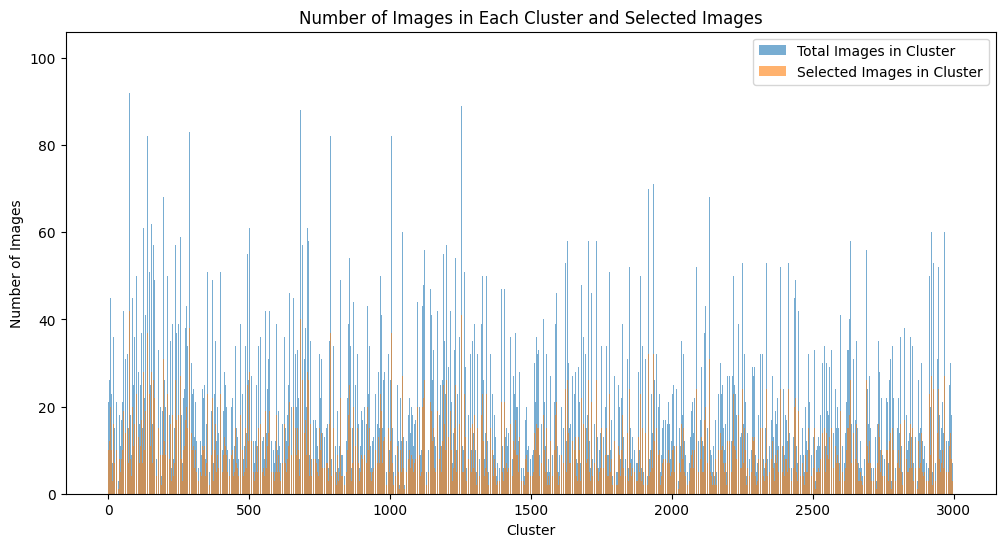

In [81]:
import matplotlib.pyplot as plt

# Count the number of images in each cluster
cluster_counts = filtered_street['Cluster'].value_counts().sort_index()

# Count the number of selected images in each cluster
selected_cluster_counts = selected_images['Cluster'].value_counts().sort_index()

# Plot the counts
plt.figure(figsize=(12, 6))
plt.bar(cluster_counts.index, cluster_counts.values, alpha=0.6, label='Total Images in Cluster')
plt.bar(selected_cluster_counts.index, selected_cluster_counts.values, alpha=0.6, label='Selected Images in Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Cluster and Selected Images')
plt.legend()
plt.show()


In [78]:
cluster_info

,Cluster,ClusterSize,SelectionQuota,ImagesToSelect
1254,1254,89,40.491356,41
184,184,78,35.486806,36
1192,1192,67,30.482257,31
167,167,67,30.482257,31
191,191,56,25.477707,26
...,...,...,...,...
2500,2500,10,4.549591,5
336,336,10,4.549591,5
366,366,10,4.549591,5
2514,2514,10,4.549591,5


In [55]:
max(filtered_street["Cluster"])

1999

KeyboardInterrupt: 

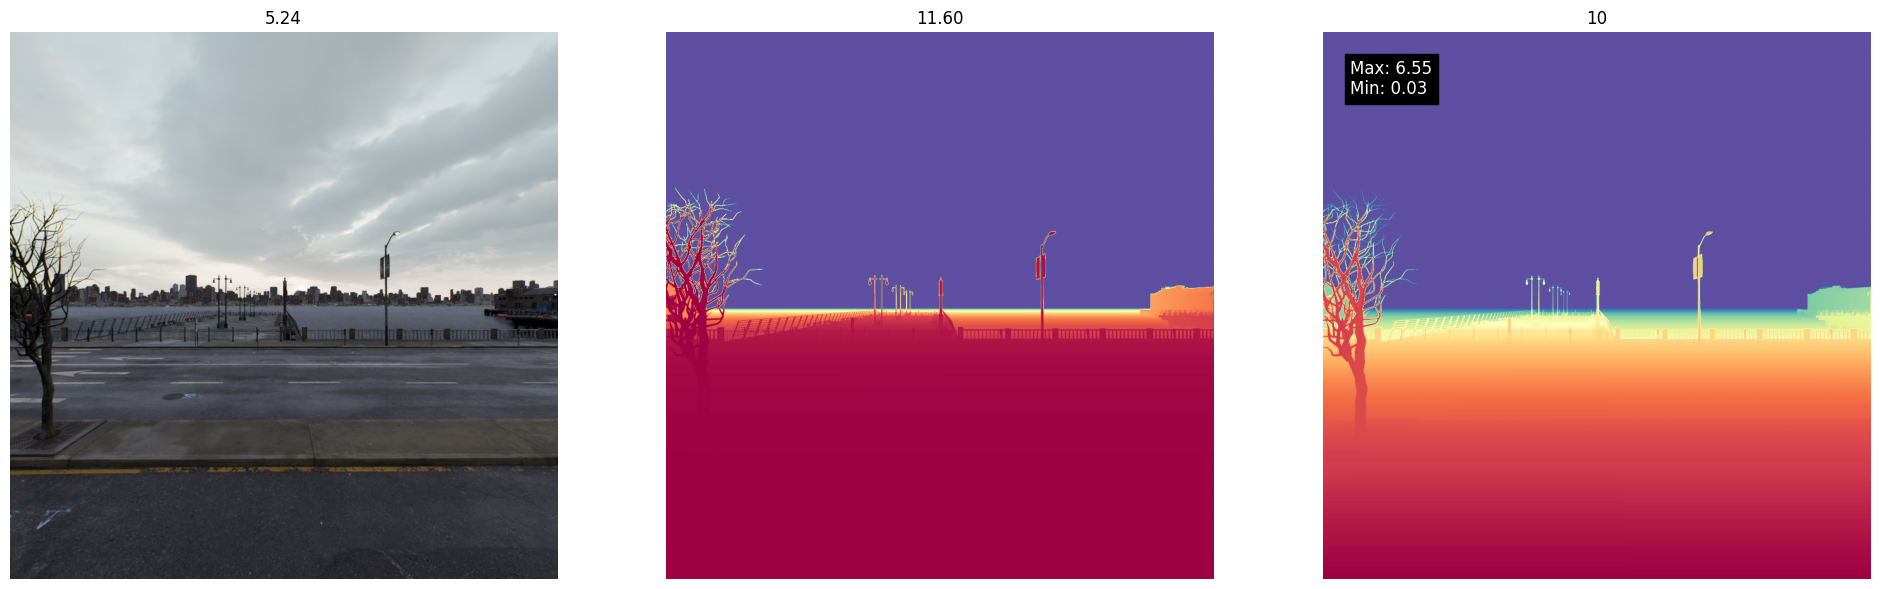

In [74]:

import os
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import time
from IPython.display import clear_output
import pandas as pd 
from utils import convert_tar_path,convert_image_path,convert_tar_path_to_sampled,load_depth
# Use inline plotting
%matplotlib inline
# df = filtered_street[filtered_street["Cluster"]==2311].sort_values(by="DistanceFromCentroid")
df = selected_images
print("Total images here:",df.shape[0])
base_path = "/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/depth_estimation_experiments/DiT/depth_datasets/MatrixCity/MatrixCity"

for i, row in df.iterrows():
    # time.sleep(2)
    # if i>30:
    #     break
    tar_file = os.path.join(base_path, row["Tar File"]) if not os.path.isabs(row["Tar File"]) else row["Tar File"]
    file_path = os.path.join(convert_tar_path(tar_file), convert_image_path(row["File Path Inside Tar"]))
    rgb_file_path = os.path.join(convert_tar_path_to_sampled(tar_file), row["File Path Inside Tar"].lstrip("./"))
    depth_image, invalid_mask = load_depth(file_path)
    depth_image_real = depth_image.copy()

    # Logarithmic depth values
    depth_image_log = np.log(depth_image)
    depth_image_new = (depth_image - depth_image.min()) / (depth_image.max() - depth_image.min())
    cmap = cmap = cm.Spectral
    depth_image_clipped = np.clip(depth_image_new, 0, 1)
    spectral_image = cmap(depth_image_clipped)[:, :, :3]  # Remove alpha channel

    # Depth values
    depth_image_new_log = (depth_image_log - depth_image_log.min()) / (depth_image_log.max() - depth_image_log.min())
    cmap = cm.Spectral
    depth_image_clipped_log = np.clip(depth_image_new_log, 0, 1)
    spectral_image_log = cmap(depth_image_clipped_log)[:, :, :3]  # Remove alpha channel

    rgb_image = plt.imread(rgb_file_path)

    # Clear the previous output
    clear_output(wait=True)

    # Create a new figure
    plt.figure(figsize=(24, 8))

    # Plot the RGB image
    plt.subplot(1, 3, 1)
    plt.imshow(rgb_image)
    plt.title(f"{row['Aesthetic Score']:.2f}")
    plt.axis('off')  # Hide axes for better visualization

    # Plot the spectral image
    plt.subplot(1, 3, 2)
    plt.imshow(spectral_image)
    plt.title(f"{row['DistanceFromCentroid']:.2f}")
    plt.axis('off')  # Hide axes for better visualization

    # Plot the spectral image with logarithmic depth
    plt.subplot(1, 3, 3)
    plt.imshow(spectral_image_log)
    plt.title(f"{row['Above 1000']}")
    plt.axis('off')  # Hide axes for better visualization

    # Add max and min values as text
    max_value = depth_image_real.max()
    min_value = depth_image_real.min()
    plt.text(
        0.05, 0.95, 
        f"Max: {max_value:.2f}\nMin: {min_value:.2f}", 
        color='white', fontsize=12, backgroundcolor='black', 
        verticalalignment='top', horizontalalignment='left', 
        transform=plt.gca().transAxes
    )
    # Save the plots for future reviews
    dir_to_save = "big_city_log_depth_visuals"
    output_path = rgb_file_path.replace("big_city", dir_to_save)
    output_dir = os.path.dirname(output_path)
    os.makedirs(output_dir, exist_ok=True)

    # Save the combined figure
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0.1)
    
    # Show the plot
    plt.show()
    # Optional: Add a short pause to control update speed

    # Close the plot to destroy the figure
    plt.close()

In [18]:
len(filtered_street[filtered_street["Cluster"]==1])

69

In [64]:
filtered_street.head(10)

,Tar File,File Path Inside Tar,Location Type,Data Type,Base File,Tar ID,Mean Depth,Median Depth,Variance Depth,Aesthetic Score,Max Depth,Min Depth,Above 1000,Above 4000,Variance in Histogram,rgb_filepath,rgb_dinov2_features,Cluster,DistanceFromCentroid
0,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./bottom_area/32312.png,street,train,bottom_area,street-train-bottom_area,0.959953,0.15510,3.789938,6.174630,6.5504,0.033550,6,5,5.442305e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-4.543567180633545, -1.9017640352249146, 2.0...",291,10.951181
1,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./bottom_area/36295.png,street,train,bottom_area,street-train-bottom_area,3.269697,1.22880,10.071843,5.375798,6.5504,0.032950,7,4,3.478751e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-0.4672984778881073, -1.1084071397781372, 1....",841,15.294290
2,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./top_area/44252.png,street,train,top_area,street-train-top_area,0.568305,0.13500,2.336344,5.583453,6.5504,0.033625,5,3,7.359238e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-0.545350193977356, -1.0685999393463135, 2.1...",683,14.509399
3,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./bottom_area/18615.png,street,train,bottom_area,street-train-bottom_area,2.014553,0.10550,8.535325,4.898019,6.5504,0.034125,6,3,4.629028e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-0.10483063012361526, -0.5973540544509888, -...",981,22.145385
4,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./bottom_area/14070.png,street,train,bottom_area,street-train-bottom_area,0.794923,0.14730,2.804179,6.056388,6.5504,0.033600,4,4,4.301368e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-0.6416122317314148, -0.12924908101558685, 2...",2876,15.448655
5,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./bottom_area/26325.png,street,train,bottom_area,street-train-bottom_area,0.969421,0.13000,4.555692,6.008266,6.5504,0.033525,6,3,6.527756e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-2.404118776321411, -1.566203236579895, 2.25...",723,13.961748
6,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./bottom_area/19640.png,street,train,bottom_area,street-train-bottom_area,1.480276,0.37740,5.194846,4.680976,6.5504,0.131100,7,6,4.276235e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-4.067441940307617, 0.7655428051948547, 4.37...",318,12.370036
7,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./left_area/36905.png,street,train,left_area,street-train-left_area,0.736937,0.13090,3.207652,6.424643,6.5504,0.033600,7,5,6.831603e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-2.6676828861236572, -1.9578661918640137, 2....",2951,13.826672
8,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./right_area/25941.png,street,train,right_area,street-train-right_area,0.805381,0.17300,3.380187,5.856761,6.5504,0.033450,7,4,6.554566e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-2.428629159927368, -0.3064862787723541, 3.3...",365,12.343439
9,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,./top_area/43560.png,street,train,top_area,street-train-top_area,0.209326,0.07005,0.551309,4.970731,6.5504,0.033550,5,3,8.366720e+10,/mnt/51eb0667-f71d-4fe0-a83e-beaff24c04fb/om/d...,"[[-3.5620951652526855, -1.215752124786377, 3.8...",442,19.927277


In [ ]:
for cluster in range(num_clusters):
    cluster_indices = filtered_street[filtered_street['Cluster'] == cluster].index.tolist()
    n_samples = samples_per_cluster
    # Distribute remaining samples to clusters
    if remaining_samples > 0:
        n_samples += 1
        remaining_samples -= 1
    # Ensure we don't sample more than available
    n_samples = min(n_samples, len(cluster_indices))
    # Randomly select indices
    selected_cluster_indices = random.sample(cluster_indices, n_samples)
    selected_indices.extend(selected_cluster_indices)

# Create the final DataFrame
selected_street = filtered_street.loc[selected_indices].reset_index(drop=True)